# Deep Dreaming

## Background

In the summer of 2015, strange images started to appear on the Internet. On July 2nd, on Twitter, user @big_soda69 posted a [photo of a bear that seemed to have been made out of dogs](https://twitter.com/big_soda69/status/616731105350275072), with dog faces and muliple dog legs sticking out of his fur . 

![](https://pbs.twimg.com/media/CI8RrBoWcAAJWBc.jpg)

The day before, user bskaggs had already posted a gallery of ["Inceptionism Art"](https://imgur.com/a/nVlLe) (!) on Imgur, a popular image sharing platform often used together with Reddit. More images appeared shortly after, on Twitter and other social media platforms, all showing similar transformations of everyday objects into nightmarish but colorful assemblages of animal body parts.

The source of these images was a computer program that was [released on GitHub](https://github.com/google/deepdream/) on July 1st, 2015. Already on June 17th, a [post on the Google Research Blog](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) had described the work behind the program, and had showed some of the generated images. The release of the source code, and [a reference to it posted to the popular news aggregator Hacker News](https://news.ycombinator.com/item?id=9815873) on July 2nd, 2015  accelerated the original post's and the source code's distribution all over the Internet, eventually leading to users trying the program on their own images. The hacker news post also referred to the program as "Deep Dream", chosing the name of the GitHub repository, and not "Inceptionism", as it was called in the original blog post. Eventually, the name "Deep Dream" would become the commonly used term for this class of visualization techniques.

On the technical level, the name "Deep Dream" references two significant aspects of the program: the fact that it was structured as a deep artificial neural network, and the fact that this neural network was used in an unusual way not to classify, but to generate images.

In the following, we are reconstructing the algorithm used to create these and many other images. As the original source code was based on the Caffe framework, which, in the meantime, has become somewhat niche, we are implementing it in Keras, based on an [example](https://github.com/keras-team/keras/blob/master/examples/deep_dream.py) provided in the Keras repository. Google also maintains a [plain Tensorflow example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb).

## Imports

To be able to use mechanisms like differentiation and backpropagation we need a high-level library that abstracts these mathematical details away from us. We are using Keras, the de-facto standard for high-level prototyping for machine learning. Keras is a front-end to the Tensorflow framework, which is one of the most widely used machine learning frameworks. We are importing the backend for Keras, too, so we can implement some parts of the program in Tensorflow directly. We are also importing an existing network architecture: InceptionV3. Because we are operating in high-dimensional vector space, we are also using Numpy, the Python library for scientific computing. Finally, we are importing a bunch of helper functions to render images within the notebook environment.

In [1]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import scipy
from keras.applications import inception_v3
from keras import backend as K

from io import BytesIO
import PIL.Image
from IPython.display import clear_output, Image, display

/home/fabian/anaconda3/envs/py36-phd/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Settings

According to the original blog post, we "pick a layer and ask the network to enhance whatever it detected." Here is an overview of the architecture of InceptionV3 (more information [here](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/) and in the [original paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf)):
    
![](https://hackathonprojects.files.wordpress.com/2016/09/74911-image03.png)

How do we know how these layers are called? We can simply load the model, add pre-trained ImageNet weights to it, and let Keras summarize it for us:

In [2]:
K.set_learning_phase(0)

# Load InceptionV3 with ImageNet pre-trained weights
model = inception_v3.InceptionV3(weights='imagenet', include_top=False) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

We can now define the layers that we would like to maximize. Other than in the original implementation, we will add a parameter to manually adjust the "influence" of each layer in the loss function. This gives us more control over the final output.

In [3]:
settings = {
    'features': {
        'mixed2': 0.2,
        'mixed3': 0.5,
        'mixed4': 2.,
        'mixed5': 1.5,
    },
}

## Image preprocessing and deprocessing

Following, we define four image processing helper functions. Basically (this holds for almost every machine learning framework) we will need to "flatten" our input image into a one-dimensional vector so it is easier to "digest" for the network. This is what the `preprocess_image` function is for (which is used in conjunction with another preprocessing function that comes with the network architecture). Conversely, we also have to define a function, `deprocess_image`, that reconstructs an image-like structure from a "flat" vector. In this function, we also need to normalize the values so they fall into the "visible range", i.e. the possible range of values that the image format we are using. Here we are normalizing from the range -1/1 to 0/255. For later in the process, we are also defining a function to resize an image, and to save an image.

In [4]:
def preprocess_image(image_path):
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0) # Inserts new axis at position 0 - TO DO: check img.shape
    img = inception_v3.preprocess_input(img) # Most likely from 3D to 1D - TO DO: check img.shape
    return img

def deprocess_image(x):
    # Check ~/.keras/keras.json to make sure "image_data_format" is set to "channels_last"
    # or print(K.image_data_format())
    x = x.reshape((x.shape[1], x.shape[2], 3)) # From 1D to 3D
    x /= 2. # Normalize from -1/1 to 0/255
    x += 0.5 # Normalize from -1/1 to 0/255
    x *= 255. # Normalize from -1/1 to 0/255
    x = np.clip(x, 0, 255).astype('uint8') # Clip to visible range
    return x

# Simple resize function based on scipy
def resize_img(img, size):
    img = np.copy(img)
    factors = (1, float(size[0]) / img.shape[1], float(size[1]) / img.shape[2], 1)
    return scipy.ndimage.zoom(img, factors, order=1)

# Simple save function based on scipy
def save_image(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)
    
def show_image(img, fmt='jpeg'):
    img = deprocess_image(np.copy(img))
    f = BytesIO()
    PIL.Image.fromarray(img).save(f, fmt)
    display(Image(data=f.getvalue()))

## Defining the loss function

With all this in place, we can implement the core of the algorithm: the loss function. First, we are building a dictionary of all the layers that are available and define the placeholder input data and loss function.

In [5]:
# Dictionary of the names of the layers and the layers themselves
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Input of the first layer, in the example: model.input
dream = model.layers[0].input 

# A TF variable (persistent)
loss = K.variable(0.) 

Now we iterate only over the layers defined above. We make sure (`assert`) that these layers are indeed part of the network and then add their [Euclidan norms=](https://en.wikipedia.org/wiki/Euclidean_distance), multiplied by the coefficient defined above, to a running sum: this sum is our loss function.

In [6]:
# Iterate only over the layers picked above
for layer_name in settings['features']: 
    
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.' # Layer in model?
    coeff = settings['features'][layer_name] # Coefficient for the layer
    x = layer_dict[layer_name].output # Output of the current layer
    print(x)
    # We avoid border artifacts by only involving non-border pixels in the loss, offset by 2 on all sides
    scaling = K.prod(K.cast(K.shape(x), 'float32')) # ?
    loss += coeff * K.sum(K.square(x[:, 2: -2, 2: -2, :])) / scaling # L2 norm

Tensor("mixed2/concat:0", shape=(?, ?, ?, 288), dtype=float32)
Tensor("mixed3/concat:0", shape=(?, ?, ?, 768), dtype=float32)
Tensor("mixed4/concat:0", shape=(?, ?, ?, 768), dtype=float32)
Tensor("mixed5/concat:0", shape=(?, ?, ?, 768), dtype=float32)


Finally, we compute the gradients of the input with respect to the loss, for each layer involved. It is important to keep in mind that what we are doing here is not, as usual with Jupyter, executing each cell immediately. Instead, we are building a computational graph, a system of placeholders that are used only when we start the training of the network.

In [7]:
# Compute the gradients of the dream w.r.t. the loss.
grads = K.gradients(loss, dream)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon()) # ?

## Defining the optimizer

Now that we have a method of computing the gradients of the input with respect to the loss, we need a method to tune it. Other than during the training of the network, we would like to *maximize* the gradients, which means that we need a gradient ascent optimizer, rather than a gradient descent optimizer. Again, keep in mind that the function `fetch_loss_and_grads` here is only a placeholder in a computational graph: at running time, `dream` will refer to our input image, and `loss` and `grads` will refer to the actual output of the actual loss function with respect to this input.

In [8]:
fetch_loss_and_grads = K.function([dream], [loss, grads])
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1]
        if max_loss is not None and loss_value > max_loss:
            break
        # print('..Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

## Hyperparameters

What do these hyperparameters intuitively correspond to?

In [9]:
step = 0.01  # Gradient ascent step size
num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale
max_loss = 10.

## Dreaming

Now we can start dreaming. First, we load an image from disk. We briefly inspect its dimensions and then add these original dimensions to a list.

In [10]:
img = preprocess_image('input2.jpg')
print(img.shape)
original_shape = img.shape[1:3]
print(original_shape)
successive_shapes = [original_shape]

(1, 533, 799, 3)
(533, 799)


Now we calculate `num_ocatve` different dimensions for the image and also add these to the list.

In [11]:
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    print(shape)
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1] # Reverse the list so we go small to original

(380, 570)
(271, 407)
(194, 291)
(138, 207)


Finally, we run the whole thing. The "trick" is to optimize the selected layers at different scales. At each step:

1. Resize current image to current shape
2. Optimize current image w.r.t. selected layers
3. Resize ("upscale") previous shape original image to current shape
4. Resize ("downscale") original shape original image to current shape
5. Find the details that are lost in the upscaling process
6. Add these details back to the optimized image

Processing image shape (138, 207)


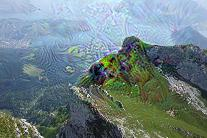

Processing image shape (194, 291)


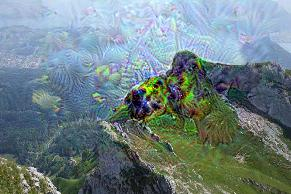

Processing image shape (271, 407)


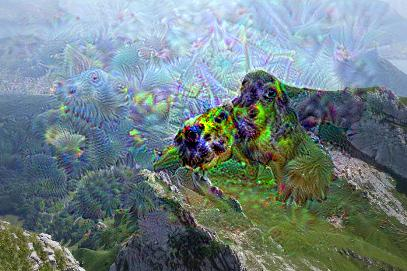

Processing image shape (380, 570)


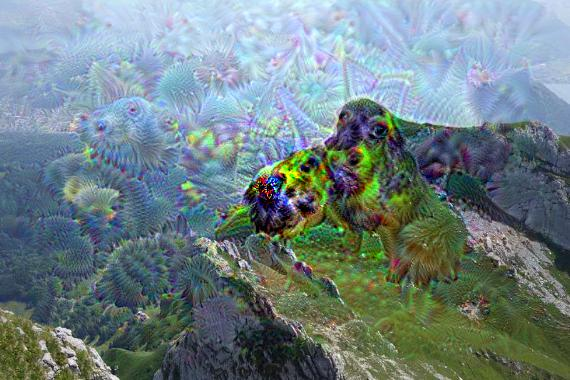

Processing image shape (533, 799)


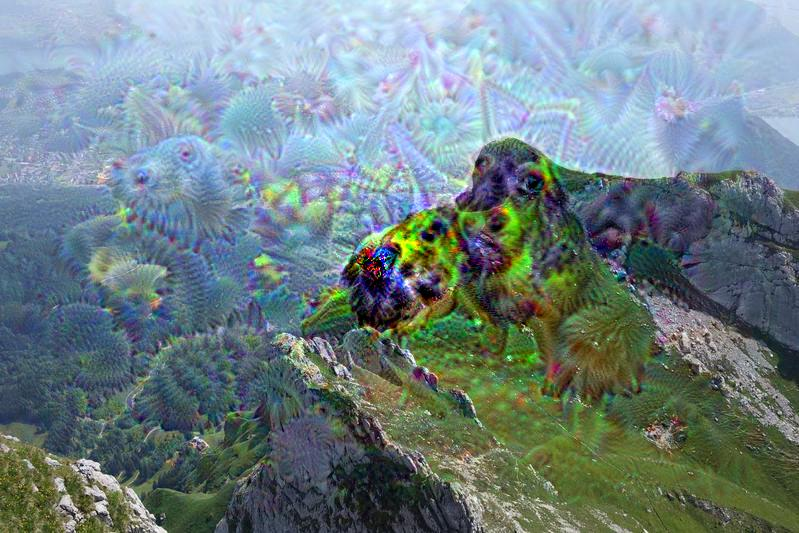

/home/fabian/anaconda3/envs/py36-phd/lib/python3.6/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [12]:
img = preprocess_image('input2.jpg') # Repeating this for clarity
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    
    # 1. Resize current image to current shape
    img = resize_img(img, shape) 
    # 2. Optimize current image w.r.t. selected layers
    img = gradient_ascent(img, iterations=iterations, step=step, max_loss=max_loss) 
    # 3. Resize ("upscale") previous shape original image to current shape
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    # 4. Resize ("downscale") original shape original image to current shape
    same_size_original = resize_img(original_img, shape)
    # 5. Find the details that are lost in the upscaling process
    lost_detail = same_size_original - upscaled_shrunk_original_img
    # 6. Add these details back to the optimized image
    img += lost_detail # Add back the lost details to the optimized image
    
    show_image(img)
    
    # Prepare for next iteration
    shrunk_original_img = resize_img(original_img, shape) #

# Save final image
save_image(img, fname='output.png')